# Creating binary model

Setting up environment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from keras import layers, Sequential


dataset_path_str = "/content/drive/MyDrive/NN/Changes_Resized_200_150/Changes"
dataset_path = pathlib.Path(dataset_path_str)

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

Creating first data pipelines without data augmentation

Found 25331 files belonging to 2 classes.
Using 20265 files for training.
Using 5066 files for validation.
['Benign', 'Malignant']


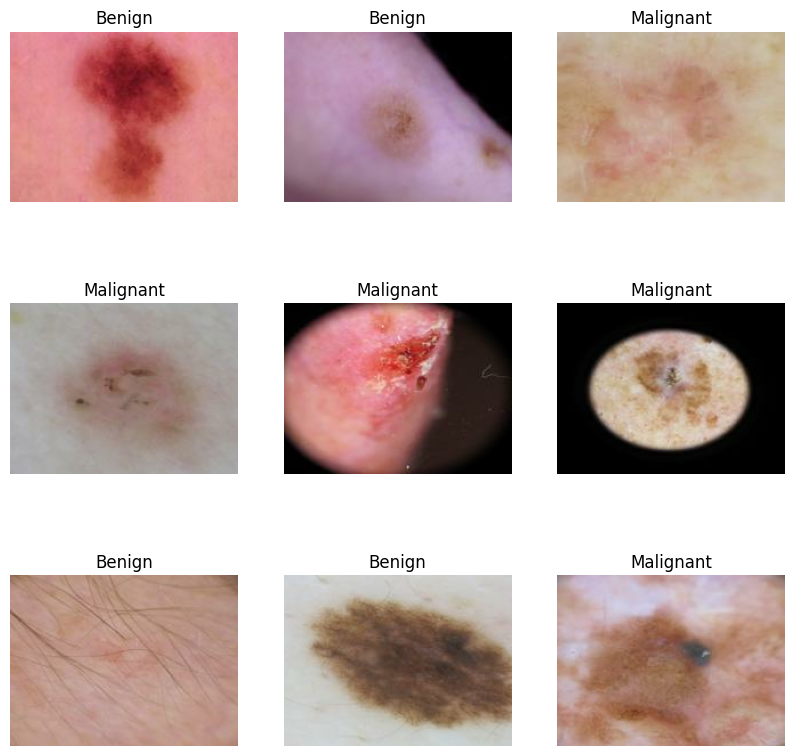

In [ ]:
seed = 297
batch_size = 32
img_height = 150
img_width = 200

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split = 0.2,
    subset = "both",
    seed = seed,
    image_size = (img_height, img_width),
    batch_size = batch_size)

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating model without augmentation and learning it for 20 epochs, top only

In [ ]:
from keras.applications.vgg19 import VGG19

vgg19_base = VGG19(input_shape = (img_height, img_width, 3),
                                  include_top = False,
                                  weights = 'imagenet')

for layer in vgg19_base.layers:
    layer.trainable = False

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  vgg19_base,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(2, activation='softmax')
])

model.compile(optimizer = keras.optimizers.RMSprop(learning_rate = 0.0001),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics = ['accuracy'])

model.summary()

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 150, 200, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 200, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 200, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 200, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 6, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 12288)             0 

Plotting results

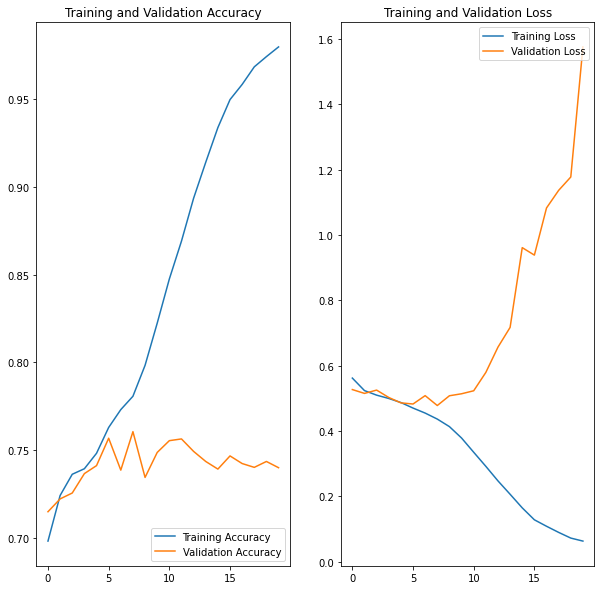

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Adding data augmentation and training model for 50 epochs top only

In [ ]:
img_height = 320
img_width = 320
epochs = 50
batch_size = 32

datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10,
        rescale=1./255)

train_generator = datagen.flow_from_directory(
        '/notebooks/320_320_binary/train',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        '/notebooks/320_320_binary/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

training_shape = (img_height, img_width, 3)
base_model = keras.applications.Xception(include_top = False,
                                         weights ='imagenet',
                                         input_shape = training_shape)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(2, activation='softmax')
])

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)

model.compile(optimizer = optimizer, loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

model.summary()

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data = validation_generator,
                    verbose = 1,
                    callbacks=[learning_rate_reduction, early_stopping_monitor])

model.save('/notebooks/models/model1_1')

Found 21109 images belonging to 2 classes.
Found 4221 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 204800)           819200    
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 

INFO:tensorflow:Assets written to: /notebooks/models/assets


INFO:tensorflow:Assets written to: /notebooks/models/assets


Training whole model for next 40 epochs 

In [ ]:
img_height = 320
img_width = 320
epochs = 40
batch_size = 32

datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10,
        rescale=1./255)

train_generator = datagen.flow_from_directory(
        '/notebooks/320_320_binary/train',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        '/notebooks/320_320_binary/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

model = keras.models.load_model('/notebooks/models/model1_1')

for layer in model.layers[0].layers:
    layer.trainable = True

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.0000001)

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)

model.compile(optimizer = optimizer, loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

model.summary()

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data = validation_generator,
                    verbose = 1,
                    callbacks=[learning_rate_reduction, early_stopping_monitor])

model.save('/notebooks/models/model1_2')

Found 21109 images belonging to 2 classes.
Found 4221 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 204800)           819200    
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 

INFO:tensorflow:Assets written to: /notebooks/models/model2/assets


INFO:tensorflow:Assets written to: /notebooks/models/model2/assets


Plotting results, model reached arround 90% on imbalanced data set

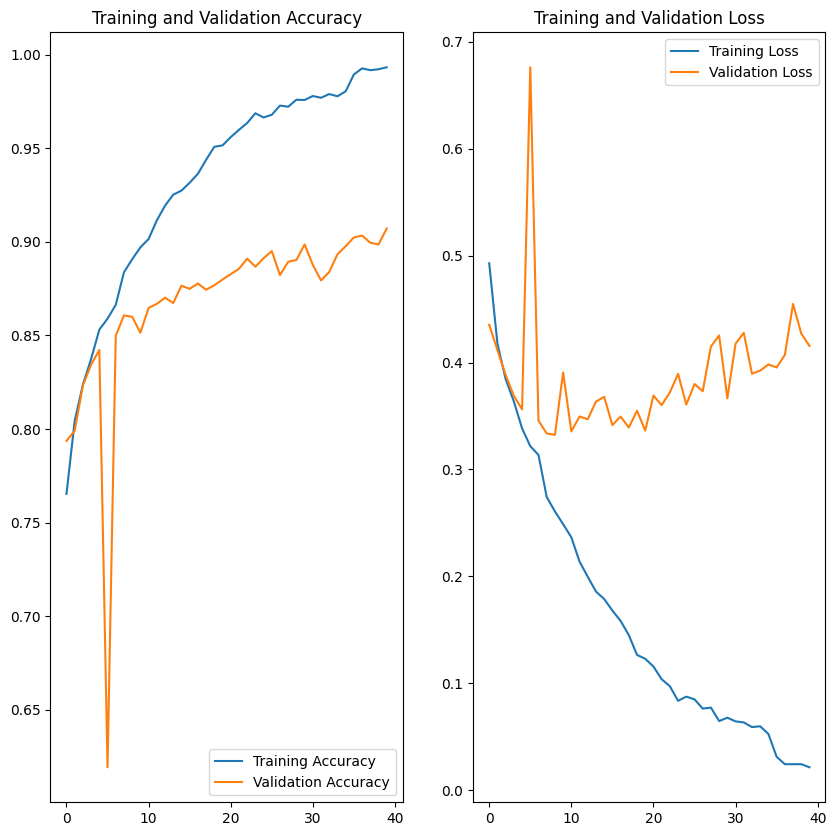

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training whole model for the next 40 epochs

In [ ]:
img_height = 320
img_width = 320
epochs = 40
batch_size = 32

datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10,
        rescale=1./255)

train_generator = datagen.flow_from_directory(
        '/notebooks/320_320_binary/train',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        '/notebooks/320_320_binary/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary')

model = keras.models.load_model('/notebooks/models/model1_2')

for layer in model.layers[0].layers:
    layer.trainable = True

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.0000001)

early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)

model.compile(optimizer = optimizer, loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

model.summary()

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data = validation_generator,
                    verbose = 1,
                    callbacks=[learning_rate_reduction, early_stopping_monitor])

model.save('/notebooks/models/model1_3')

Found 21109 images belonging to 2 classes.
Found 4221 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 204800)           819200    
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 128)               26214528  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 

INFO:tensorflow:Assets written to: /notebooks/models/model3/assets


INFO:tensorflow:Assets written to: /notebooks/models/model3/assets


Evaluating models on balanced and imbalanced data sets

In [ ]:
img_height = 320
img_width = 320
batch_size = 32

datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range = 10,
        rescale=1./255)

print('Loading imbalanced data set (representation of benign class is above twice as great as malignant):')
imbalanced_validation_generator = datagen.flow_from_directory(
        '/notebooks/320_320_binary/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle = False)

print('Loading balanced data set (both classes has equal represenation):')
balanced_validation_generator = datagen.flow_from_directory(
        '/notebooks/320_320_eq_binary/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle = False)

model1 = keras.models.load_model('/notebooks/models/model1_1')
model2 = keras.models.load_model('/notebooks/models/model1_2')
model3 = keras.models.load_model('/notebooks/models/model1_3')
print('Loaded 3 models:')
print('> model1 - achieved about 81 % of accuracy during training')
print('> model2 - achieved about 90 % of accuracy during training')
print('> model3 - achieved about 91 % of accuracy during training')

imbalanced_labels = imbalanced_validation_generator.labels
balanced_labels = balanced_validation_generator.labels

print('Predicting model1 on imbalanced data set:')
imbalanced_predictions1 = np.argmax(np.round(model1.predict(imbalanced_validation_generator)), axis=1)
print('Predicting model2 on imbalanced data set:')
imbalanced_predictions2 = np.argmax(np.round(model2.predict(imbalanced_validation_generator)), axis=1)
print('Predicting model3 on imbalanced data set:')
imbalanced_predictions3 = np.argmax(np.round(model3.predict(imbalanced_validation_generator)), axis=1)
print('Predicting model1 on balanced data set:')
balanced_predictions1 = np.argmax(np.round(model1.predict(balanced_validation_generator)), axis=1)
print('Predicting model2 on balanced data set:')
balanced_predictions2 = np.argmax(np.round(model2.predict(balanced_validation_generator)), axis=1)
print('Predicting model3 on balanced data set:')
balanced_predictions3 = np.argmax(np.round(model3.predict(balanced_validation_generator)), axis=1)

print('Evaluating model1 on imbalanced data set:')
model1.evaluate(imbalanced_validation_generator)
print('Evaluating model2 on imbalanced data set:')
model2.evaluate(imbalanced_validation_generator)
print('Evaluating model3 on imbalanced data set:')
model3.evaluate(imbalanced_validation_generator)
print('Evaluating model1 on balanced data set:')
model1.evaluate(balanced_validation_generator)
print('Evaluating model2 on balanced data set:')
model2.evaluate(balanced_validation_generator)
print('Evaluating model3 on balanced data set:')
model3.evaluate(balanced_validation_generator)

Loading imbalanced data set (representation of benign class is above twice as great as malignant):
Found 4221 images belonging to 2 classes.
Loading balanced data set (both classes has equal represenation):
Found 2816 images belonging to 2 classes.
Loaded 3 models:
> model1 - achieved about 81 % of accuracy during training
> model2 - achieved about 90 % of accuracy during training
> model3 - achieved about 91 % of accuracy during training
Predicting model1 on imbalanced data set:
132/132 [==============================] - 70s 530ms/step
Predicting model2 on imbalanced data set:
132/132 [==============================] - 72s 542ms/step
Predicting model3 on imbalanced data set:
132/132 [==============================] - 72s 540ms/step
Predicting model1 on balanced data set:
88/88 [==============================] - 47s 537ms/step
Predicting model2 on balanced data set:
88/88 [==============================] - 47s 535ms/step
Predicting model3 on balanced data set:
88/88 [==================

[0.09768049418926239, 0.9850852489471436]

Checking confusion matrices and precision 

In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

print('Confusion matrix for model1 on imbalanced data set:')
imbalanced_matrix1 = tf.math.confusion_matrix(imbalanced_labels, imbalanced_predictions1)
print(imbalanced_matrix1.numpy())
print('Precision for model1 on imbalanced data set:')
precision.update_state(imbalanced_labels, imbalanced_predictions1)
print(precision.result().numpy())
print('Recall for model1 on imbalanced data set:')
recall.update_state(imbalanced_labels, imbalanced_predictions1)
print(recall.result().numpy())
print('F1 score for model1 on imbalanced data set:')
print((2 * recall.result().numpy() * precision.result().numpy())/(recall.result().numpy() + precision.result().numpy()))
precision.reset_state()
recall.reset_state()

print('\nConfusion matrix for model2 on imbalanced data set:')
imbalanced_matrix2 = tf.math.confusion_matrix(imbalanced_labels, imbalanced_predictions2)
print(imbalanced_matrix2.numpy())
print('Precision for model2 on imbalanced data set:')
precision.update_state(imbalanced_labels, imbalanced_predictions2)
print(precision.result().numpy())
print('Recall for model2 on imbalanced data set:')
recall.update_state(imbalanced_labels, imbalanced_predictions2)
print(recall.result().numpy())
print('F1 score for model2 on imbalanced data set:')
print((2 * recall.result().numpy() * precision.result().numpy())/(recall.result().numpy() + precision.result().numpy()))
precision.reset_state()
recall.reset_state()

print('\nConfusion matrix for model3 on imbalanced data set:')
imbalanced_matrix3 = tf.math.confusion_matrix(imbalanced_labels, imbalanced_predictions3)
print(imbalanced_matrix3.numpy())
print('Precision for model3 on imbalanced data set:')
precision.update_state(imbalanced_labels, imbalanced_predictions3)
print(precision.result().numpy())
print('Recall for model3 on imbalanced data set:')
recall.update_state(imbalanced_labels, imbalanced_predictions3)
print(recall.result().numpy())
print('F1 score for model3 on imbalanced data set:')
print((2 * recall.result().numpy() * precision.result().numpy())/(recall.result().numpy() + precision.result().numpy()))
precision.reset_state()
recall.reset_state()

print('\nConfusion matrix for model1 on balanced data set:')
balanced_matrix1 = tf.math.confusion_matrix(balanced_labels, balanced_predictions1)
print(balanced_matrix1.numpy())
print('Precision for model1 on balanced data set:')
precision.update_state(balanced_labels, balanced_predictions1)
print(precision.result().numpy())
print('Recall for model1 on balanced data set:')
recall.update_state(balanced_labels, balanced_predictions1)
print(recall.result().numpy())
print('F1 score for model1 on balanced data set:')
print((2 * recall.result().numpy() * precision.result().numpy())/(recall.result().numpy() + precision.result().numpy()))
precision.reset_state()
recall.reset_state()

print('\nConfusion matrix for model2 on balanced data set:')
balanced_matrix2 = tf.math.confusion_matrix(balanced_labels, balanced_predictions2)
print(balanced_matrix2.numpy())
print('Precision for model2 on balanced data set:')
precision.update_state(balanced_labels, balanced_predictions2)
print(precision.result().numpy())
print('Recall for model2 on balanced data set:')
recall.update_state(balanced_labels, balanced_predictions2)
print(recall.result().numpy())
print('F1 score for model2 on balanced data set:')
print((2 * recall.result().numpy() * precision.result().numpy())/(recall.result().numpy() + precision.result().numpy()))
precision.reset_state()
recall.reset_state()

print('\nConfusion matrix for model3 on balanced data set:')
balanced_matrix3 = tf.math.confusion_matrix(balanced_labels, balanced_predictions3)
print(balanced_matrix3.numpy())
print('Precision for model2 on balanced data set:')
precision.update_state(balanced_labels, balanced_predictions3)
print(precision.result().numpy())
print('Recall for model2 on balanced data set:')
recall.update_state(balanced_labels, balanced_predictions3)
print(recall.result().numpy())
print('F1 score for model2 on balanced data set:')
print((2 * recall.result().numpy() * precision.result().numpy())/(recall.result().numpy() + precision.result().numpy()))
precision.reset_state()
recall.reset_state()

Confusion matrix for model1 on imbalanced data set:
[[2496  313]
 [ 496  916]]
Precision for model1 on imbalanced data set:
0.7453214
Recall for model1 on imbalanced data set:
0.6487252
F1 score for model1 on imbalanced data set:
0.6936766639991477

Confusion matrix for model2 on imbalanced data set:
[[2637  172]
 [ 225 1187]]
Precision for model2 on imbalanced data set:
0.87343633
Recall for model2 on imbalanced data set:
0.8406516
F1 score for model2 on imbalanced data set:
0.8567303906377449

Confusion matrix for model3 on imbalanced data set:
[[2667  142]
 [ 228 1184]]
Precision for model3 on imbalanced data set:
0.892911
Recall for model3 on imbalanced data set:
0.8385269
F1 score for model3 on imbalanced data set:
0.8648648638174524

Confusion matrix for model1 on balanced data set:
[[1283  121]
 [ 411 1001]]
Precision for model1 on balanced data set:
0.89215684
Recall for model1 on balanced data set:
0.7089235
F1 score for model1 on balanced data set:
0.7900552137115294

Confusi